# Evaluation Analysis of Trained Models

## Libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from typing import List, Optional
from mpl_toolkits.mplot3d import Axes3D

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import constants, common
from utils.dataset_loader import PolicyDatasetLoader

from optimization import functions
from optimization.updater import Updater

from environment.environment import RobotEnvironment
from environment.buffer import ReplayBuffer

from models.policy_model import RobotPolicy
from models.reward_model import RewardFunction

In [2]:
pd.set_option("display.max_columns",
              None)

## Functions

In [3]:
def plt_2D_plotting(df: pd.DataFrame,
                    column_names: List[str],
                    x_axis_name: str,
                    y_axis_name: str,
                    x_label_name: str,
                    title_label_name: str) -> None:
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(column_names, list) or not all(isinstance(name, str) for name in column_names):
        raise TypeError("Input 'column_names' must be a list of strings.")
    if not all(name in df.columns for name in column_names):
        raise ValueError("Invalid column name(s) for column_names.")
    if not all(isinstance(label, str) for label in [x_axis_name, y_axis_name, title_label_name]):
        raise TypeError("Axis labels and title must be strings.")

    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Invalid column name: {column_name}")

    if len(column_names) not in [1, 2]:
        raise ValueError("Invalid number of columns to plot. Must be 1 or 2.")

    if not isinstance(x_axis_name, str) or not isinstance(y_axis_name, str):
        raise TypeError("Axis names must be strings.")
    if not isinstance(x_label_name, str):
        raise TypeError("Column name for x axis must be string.")
    if not isinstance(title_label_name, str):
        raise TypeError("Title must be a string.")
    
    for column_name in column_names:
        plt.scatter(df[x_label_name], df[column_name],
                    label=column_name)
    
    if len(column_names) == 2:
        mae_avg = np.mean(np.abs(df[column_names[0]] - df[column_names[1]]))
        mae_max = np.max(np.abs(df[column_names[0]] - df[column_names[1]]))
        
        error_text = f"Avg. MAE = {mae_avg:.5f} m\nMax. MAE = {mae_max:.5f} m"
        
        plt.text(0.95, 0.05,
                 error_text,
                 transform=plt.gca().transAxes,
                 verticalalignment="bottom",
                 horizontalalignment="right",
                 bbox=dict(facecolor="white", alpha=0.8))
    
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.title(title_label_name)
    
    plt.legend(loc="upper right")
    
    plt.show()

In [4]:
def plot_2D_label_vs_pred_states(axs: List[plt.Axes],
                                 colors: List[str],
                                 state_number_series: pd.Series,
                                 label_data_df: pd.DataFrame,
                                 estim_data_df: pd.DataFrame) -> None:
    
    if not isinstance(axs, list):
        raise TypeError("Input 'axs' in plot_2D_label_vs_pred_states function must be a list.")
    if not all(isinstance(ax, plt.Axes) for ax in axs):
        raise TypeError("All elements in 'axs' must be instances of matplotlib.axes._subplots.AxesSubplot.")
    if not isinstance(colors, list):
        raise TypeError("Input 'colors' in plot_2D_label_vs_pred_states function must be a list.")
    if not all(isinstance(color, str) for color in colors):
        raise TypeError("All elements in 'colors' must be strings representing colors.")
    if not isinstance(state_number_series, pd.Series):
        raise TypeError("Input 'state_number_series' in plot_2D_label_vs_pred_states function must be a pandas Series.")
    if not isinstance(label_data_df, pd.DataFrame):
        raise TypeError("Input 'label_data_df' in plot_2D_label_vs_pred_states function must be a pandas DataFrame.")
    if not isinstance(estim_data_df, pd.DataFrame):
        raise TypeError("Input 'estim_data_df' in plot_2D_label_vs_pred_states function must be a pandas DataFrame.")
    
    label_distance_to_object = label_data_df.iloc[:, 0]
    label_distance_to_target = label_data_df.iloc[:, 1]
    label_distance_to_ground = label_data_df.iloc[:, 2]
    
    estim_distance_to_object = estim_data_df.iloc[:, 0]
    estim_distance_to_target = estim_data_df.iloc[:, 1]
    estim_distance_to_ground = estim_data_df.iloc[:, 2]
    
    if len(axs) == 1:
        
        axs[0].plot(state_number_series, label_distance_to_target,
                    color=colors[0],
                    label="Label: Distance to Target")
        axs[0].plot(state_number_series, estim_distance_to_target,
                    color=colors[3],
                    linestyle="--",
                    label="Estimation: Distance to Target")
        
        axs[0].plot(state_number_series, label_distance_to_object,
                    color=colors[1],
                    label="Label: Distance to Obstacle")
        axs[0].plot(state_number_series, estim_distance_to_object,
                    color=colors[4],
                    linestyle="--",
                    label="Estimation: Distance to Obstacle")
        
        axs[0].plot(state_number_series, label_distance_to_ground,
                    color=colors[2],
                    label="Distance to Ground")
        axs[0].plot(state_number_series, estim_distance_to_ground,
                    color=colors[5],
                    linestyle="--",
                    label="Estimation: Distance to Ground")
    
    else:
        axs[0].plot(state_number_series, label_distance_to_target,
                    color=colors[0])
        axs[0].set_title("Distance to Target")
        axs[1].plot(state_number_series, label_distance_to_object,
                    color=colors[1])
        axs[1].set_title("Distance to Obstacle")
        axs[2].plot(state_number_series, label_distance_to_ground,
                    color=colors[2])
        axs[2].set_title("Distance to Ground")
        
        axs[0].plot(state_number_series, estim_distance_to_target,
                    color=colors[3],
                    linestyle="--")
        axs[1].plot(state_number_series, estim_distance_to_object,
                    color=colors[4],
                    linestyle="--")
        axs[2].plot(state_number_series, estim_distance_to_ground,
                    color=colors[5],
                    linestyle="--")

In [5]:
def plot_3D_vector(ax: Axes3D,
                   list_trajectory: List[torch.Tensor],
                   color: str,
                   traj_s: int,
                   start_s: int,
                   end_s: int,
                   label: str,
                   env: Optional[RobotEnvironment] = None) -> None:

    if not isinstance(list_trajectory, list):
        raise TypeError("list_trajectory should be a list of torch.Tensor")
    if not all(isinstance(position, torch.Tensor) for position in list_trajectory):
        raise TypeError("Each element in list_trajectory should be a torch.Tensor")
    
    state_1 = [object_dist[0].item() for object_dist in list_trajectory]
    state_2 = [target_dist[1].item() for target_dist in list_trajectory]
    state_3 = [ground_dist[2].item() for ground_dist in list_trajectory]
    
    scatter_traj = ax.scatter(state_1, state_2, state_3,
                              c=color, marker="o", s=traj_s, label=label)
    
    scatter_start = ax.scatter(state_1[0], state_2[0], state_3[0],
                               c="green", marker="*", s=start_s, label="Start Position")
    scatter_end = ax.scatter(state_1[-1], state_2[-1], state_3[-1],
                             c="blue", marker="X", s=end_s, label="End Position")
    
    # do not specify environment object when the input is state vector
    if env is not None:
        target_location_normalized = common.normalize_action(action=np.array(constants.TARGET_LOCATION).reshape((1, len(constants.TARGET_LOCATION))),
                                                             norm_range_list=env.action_norms[:3])[0]
        scatter_target = ax.scatter(target_location_normalized[0], target_location_normalized[1], target_location_normalized[2],
                                    c="black", marker="+", s=end_s, label="Target Location")

In [6]:
def plot_3D_vector_comparison(ax: plt.Axes,
                              label_trajectory_df: pd.DataFrame,
                              estim_trajectory_df: pd.DataFrame,
                              object_position: List[float],
                              colors: List[str],
                              traj_s: int,
                              start_s: int,
                              end_s: int) -> None:
    
    if not isinstance(ax, plt.Axes):
        raise TypeError("Input 'ax' must be an instance of matplotlib Axes.")
    if not isinstance(label_trajectory_df, pd.DataFrame) or not isinstance(estim_trajectory_df, pd.DataFrame):
        raise TypeError("Input 'label_trajectory_df' and 'estim_trajectory_df' must be pandas DataFrames.")
    if not isinstance(object_position, list) or len(object_position) != 3 or not all(isinstance(pos, (int, float)) for pos in object_position):
        raise TypeError("Input 'object_position' must be a list of three integers or floats.")
    if not isinstance(colors, list):
        raise TypeError("Input 'colors' in plot_trajectory function must be a list.")
    if not all(isinstance(color, str) for color in colors):
        raise TypeError("All elements in 'colors' must be strings representing colors.")
    if not isinstance(traj_s, int) or not isinstance(start_s, int) or not isinstance(end_s, int):
        raise TypeError("Input 'traj_s', 'start_s', and 'end_s' must be integers.")
    
    # Additional checks for DataFrame columns
    for col_df, col_name in zip([label_trajectory_df, estim_trajectory_df], ['label_trajectory_df', 'estim_trajectory_df']):
        for col in col_df.columns:
            if not isinstance(col_df[col], pd.Series):
                raise TypeError(f"Column '{col}' of '{col_name}' must be a pandas Series.")
    
    start_index = 0
    end_index = -1
    
    x_label = label_trajectory_df.iloc[:, 0]
    y_label = label_trajectory_df.iloc[:, 1]
    z_label = label_trajectory_df.iloc[:, 2]
    
    x_estim = estim_trajectory_df.iloc[:, 0]
    y_estim = estim_trajectory_df.iloc[:, 1]
    z_estim = estim_trajectory_df.iloc[:, 2]
    
    if not isinstance(x_label, pd.Series) or not isinstance(y_label, pd.Series) or not isinstance(z_label, pd.Series):
        raise TypeError("Columns of 'label_trajectory_df' must be pandas Series.")
    if not isinstance(x_estim, pd.Series) or not isinstance(y_estim, pd.Series) or not isinstance(z_estim, pd.Series):
        raise TypeError("Columns of 'estim_trajectory_df' must be pandas Series.")
    
    scatter_traj = ax.scatter(x_label, y_label, z_label,
                              c=colors[0], marker="o", s=traj_s, label="Human Demonstration")
    scatter_traj = ax.scatter(x_estim, y_estim, z_estim,
                              c=colors[1], marker="o", s=traj_s, label="Robot Execution")
    
    scatter_start = ax.scatter(x_label.iloc[start_index], y_label.iloc[start_index], z_label.iloc[start_index],
                               c="green", marker="*", s=start_s, label="Start Position")
    scatter_end = ax.scatter(x_label.iloc[end_index], y_label.iloc[end_index], z_label.iloc[end_index],
                             c="blue", marker="X", s=end_s, label="Demonstration End Position")
    scatter_end = ax.scatter(x_estim.iloc[end_index], y_estim.iloc[end_index], z_estim.iloc[end_index],
                             c="lightblue", marker="X", s=end_s, label="Robot End Position")
    
    ax.plot(x_label, y_label, z_label,
            color=colors[0], linestyle="--", linewidth=1)
    ax.plot(x_estim, y_estim, z_estim,
            color=colors[1], linestyle="--", linewidth=1)
    
    scatter_object = ax.scatter(object_position[0], object_position[1], object_position[2],
                                c="red", marker="s", s=80, label="Obstacle Location")

## Initialization

In [7]:
# available training machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training Device: ", device)

configs = functions.setup_config(device=device)

Training Device:  cpu
Current Time:  Feb_22_2024-09_21_33


## Load Dataset

In [8]:
# create and return preliminary base paths
json_paths, results_path = functions.get_directories(parent_directory=parent_directory,
                                                     data_folder_name=constants.TEST_COLLECTION_DATE)

# load test demonstrations dataset
all_data = PolicyDatasetLoader(demo_data_json_paths=json_paths)

# get all indice numbers where the new trajectory is initialized in the dataset
trajectory_indices = functions.find_indices_of_trajectory_changes(dataset=all_data)


================== Policy Dataset Loader ==================

Number of Trajectories:  5
Each Trajectory Length:  20
Full Demo Dataset Size:  107


## Create and Load Pre-Trained Reward and Policy Models and Parameters

In [9]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             device=configs.device)
reward_network = RewardFunction(state_size=configs.state_size,
                                hidden_size=configs.hidden_size,
                                out_size=configs.reward_size,
                                device=configs.device)

In [10]:
# folder name where policy model parameters are located ("results / policy_network_params / loading_folder_name")
policy_loading_folder_name = constants.POLICY_LOADING_FOLDER
policy_params_name = constants.POLICY_PARAMS_NAME

# folder name where reward model parameters are located ("results / reward_network_params / loading_folder_name")
reward_loading_folder_name = constants.REWARD_LOADING_FOLDER
reward_params_name = constants.REWARD_PARAMS_NAME

# load pretrained policy network parameters if the pre-trained model is available
policy_network = functions.load_policy_from_path(policy_network=policy_network,
                                                 results_path=results_path,
                                                 policy_loading_folder_name=policy_loading_folder_name,
                                                 policy_params_name=policy_params_name)

# load pretrained reward network parameters if the pre-trained model is available
reward_network = functions.load_reward_from_path(reward_network=reward_network,
                                                 results_path=results_path,
                                                 reward_loading_folder_name=reward_loading_folder_name,
                                                 reward_params_name=reward_params_name)

In [11]:
# model loss functions
updater_obj = Updater(configs=configs,
                      policy_network=policy_network,
                      reward_network=reward_network)

## Environment Setup

In [12]:
# construct custom environment for reward function training
env = RobotEnvironment()
env.set_reward_network(reward_network)
env.is_reward_inference = True

# create a replay buffer class object
replay_buffer = ReplayBuffer(capacity=configs.replay_buffer_capacity)

## Test Trained Models on Demonstration Dataset Samples Individually

In [13]:
# initialize empty tensors for demonstration and sample trajectories
trajectory_dataframes = []
data_demo_tensor, data_robo_tensor = torch.tensor([]), torch.tensor([])

# get list of demonstration trajectories for training and analysis
for traj_start_index in range(len(trajectory_indices)):
    traj_df, _, _, _ = functions.get_estimated_rewards(configs=configs,
                                                       updater_obj=updater_obj,
                                                       data_loader=all_data,
                                                       policy_network=policy_network,
                                                       reward_network=reward_network,
                                                       trajectory_indices=trajectory_indices,
                                                       traj_start_index=traj_start_index,
                                                       is_inference_reward=True,
                                                       is_inference_policy=True,
                                                       is_deterministic=True)
    trajectory_dataframes.append(traj_df)
    del traj_df

In [14]:
# choose one trajectory to analyze out of human demonstrations
test_trajectory = trajectory_dataframes[1]
test_trajectory

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,action_label_norm_1,action_label_norm_2,action_label_norm_3,action_label_norm_4,action_label_norm_5,action_label_norm_6,action_label_norm_7,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,action_label_denorm_4,action_label_denorm_5,action_label_denorm_6,action_label_denorm_7,action_pred_logprob_1,action_pred_norm_1,action_pred_norm_2,action_pred_norm_3,action_pred_norm_4,action_pred_norm_5,action_pred_norm_6,action_pred_norm_7,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_std_4,action_pred_std_5,action_pred_std_6,action_pred_std_7,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,action_pred_denorm_4,action_pred_denorm_5,action_pred_denorm_6,action_pred_denorm_7,trajectory_index,state_number,gnll_loss,state_est_norm_1,state_est_norm_2,state_est_norm_3,state_est_denorm_1,state_est_denorm_2,state_est_denorm_3,next_state_label_norm_1,next_state_label_norm_2,next_state_label_norm_3,next_state_label_denorm_1,next_state_label_denorm_2,next_state_label_denorm_3,next_state_est_norm_1,next_state_est_norm_2,next_state_est_norm_3,next_state_est_denorm_1,next_state_est_denorm_2,next_state_est_denorm_3
0,0.147466242313,0.467295646667,0.234900206327,0.442398726940,1.401886940002,0.704700618982,-0.191174075007,-0.220844075084,-0.350101232529,-0.415037274361,0.907803595066,-0.036801256239,-0.047774054110,-0.382348179817,-0.441688179970,0.536152720451,-0.415037274361,0.907803535461,-0.036801278591,-0.047774076462,11.686359405518,-0.261803001165,-0.132010921836,-0.265531986952,0.029413059354,0.942202389240,-0.018900411204,-0.052651848644,0.079801537097,0.065943047404,0.064113177359,0.288209766150,0.086193777621,0.041087899357,0.039266582578,-0.523606061935,-0.264021873474,0.627846896648,0.029413104057,0.942202329636,-0.018900394440,-0.052651822567,1,0,-8.146063804626,0.147466242313,0.467295646667,0.234900206327,0.442398726940,1.401886940002,0.704700618982,0.147466968229,0.467288055707,0.234884240150,0.442400904687,1.401864167121,0.704652720451,0.100243798569,0.438448851461,0.265448965549,0.300731395708,1.315346554383,0.796346896648
1,0.147466957569,0.467288047075,0.234884247184,0.442400872707,1.401864141226,0.704652741551,-0.201054617763,-0.218110561371,-0.339347422123,-0.404651284218,0.911426961422,-0.033471338451,-0.066617257893,-0.402109265327,-0.436221122742,0.547812521458,-0.404651284218,0.911427021027,-0.033471345901,-0.066617250443,11.426339149475,-0.265140175819,-0.067110352218,-0.235963091254,0.071152381599,0.937741100788,-0.012289855629,-0.056938465685,0.081654891372,0.068950593472,0.066654391587,0.282482475042,0.090371854603,0.043836224824,0.041760716587,-0.530280351639,-0.134220719337,0.659906983376,0.071152329445,0.937741041183,-0.012289881706,-0.056938469410,1,1,-5.912944793701,0.100243799388,0.438448846340,0.265448957682,0.300731398165,1.315346539021,0.796346873045,0.145423367302,0.467837366753,0.238770840486,0.436270101906,1.403512100258,0.716312521458,0.071650742921,0.412696907554,0.276135661125,0.214952228763,1.238090722661,0.828406983376
2,0.145423367620,0.467837363482,0.238770857453,0.436270102859,1.403512090445,0.716312572360,-0.220692381263,-0.200014054775,-0.326744854450,-0.380247831345,0.922811985016,-0.045023951679,-0.042455885559,-0.441384792328,-0.400028109550,0.561476886272,-0.380247831345,0.922811985016,-0.045023977757,-0.042455911636,11.220210075378,-0.265331506729,-0.013198197819,-0.234840288758,0.108952239156,0.933385848999,-0.008161452599,-0.056979034096,0.082583911717,0.071488298476,0.069824896753,0.275701642036,0.094131782651,0.045986048877,0.043807949871,-0.530663013458,-0.026396393776,0.661124408245,0.108952283859,0.933385848999,-0.008161425591,-0.056979060173,1,2,-4.836649894714,0.071650743484,0.412696897984,0.276135653257,0.214952230453,1.238090693951,0.828406959772,0.134077545263,0.460489536140,0.243325628757,0.402232635790,1.3814686084

## Visualize Human Demonstration vs. Trained Policy Execution Trajectory

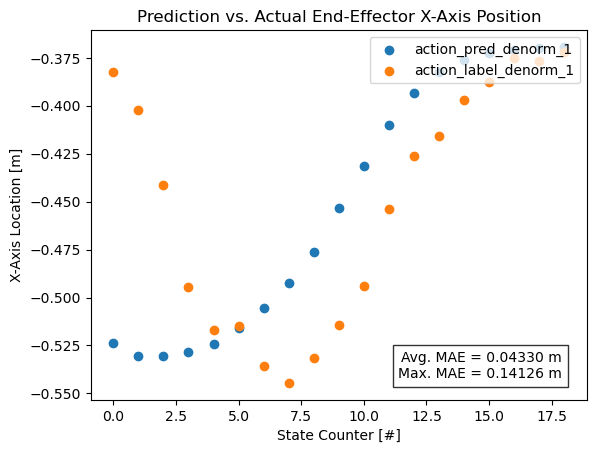

In [15]:
action_1_columns = [constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_1",
                    constants.ACTION_DENORMALIZED_LABEL_NAME + "_1"]
action_1_title_name = "Prediction vs. Actual End-Effector X-Axis Position"
action_1_y_axis_name = "X-Axis Location [m]"

plt_2D_plotting(df=test_trajectory,
                column_names=action_1_columns,
                x_axis_name="State Counter [#]",
                y_axis_name=action_1_y_axis_name,
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name=action_1_title_name)

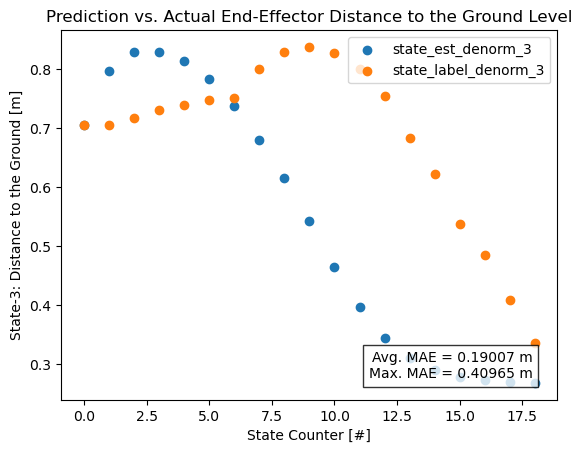

In [16]:
state_3_columns = [constants.STATE_ESTIMATION_DENORMALIZED_NAME + "_3",
                    constants.STATE_DENORMALIZED_LABEL_NAME + "_3"]
state_3_title_name = "Prediction vs. Actual End-Effector Distance to the Ground Level"
state_3_y_axis_name = "State-3: Distance to the Ground [m]"

plt_2D_plotting(df=test_trajectory,
                column_names=state_3_columns,
                x_axis_name="State Counter [#]",
                y_axis_name=state_3_y_axis_name,
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name=state_3_title_name)

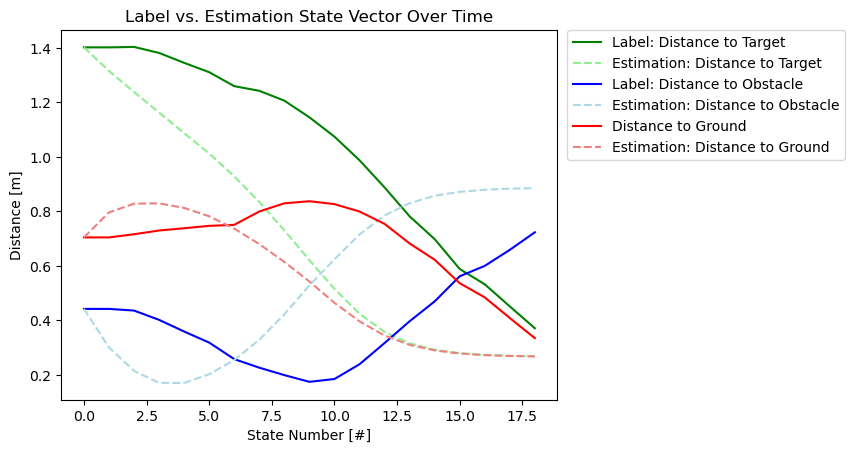

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

state_number_series = test_trajectory[constants.STATE_NUMBER_COLUMN]
state_label_df = test_trajectory[[
    constants.STATE_DENORMALIZED_LABEL_NAME + "_1",
    constants.STATE_DENORMALIZED_LABEL_NAME + "_2",
    constants.STATE_DENORMALIZED_LABEL_NAME + "_3",
]]
state_estim_df = test_trajectory[[
    constants.STATE_ESTIMATION_DENORMALIZED_NAME + "_1",
    constants.STATE_ESTIMATION_DENORMALIZED_NAME + "_2",
    constants.STATE_ESTIMATION_DENORMALIZED_NAME + "_3",
]]

plot_2D_label_vs_pred_states(axs=[ax],
                             colors=["green", "blue", "red", "lightgreen", "lightblue", "lightcoral"],
                             state_number_series=state_number_series,
                             label_data_df=state_label_df,
                             estim_data_df=state_estim_df)

ax.set_xlabel("State Number [#]")
ax.set_ylabel("Distance [m]")
ax.set_title("Label vs. Estimation State Vector Over Time")

ax.legend(bbox_to_anchor=(1.02, 1),
          loc="upper left", borderaxespad=0.0)

plt.show()

<IPython.core.display.Javascript object>


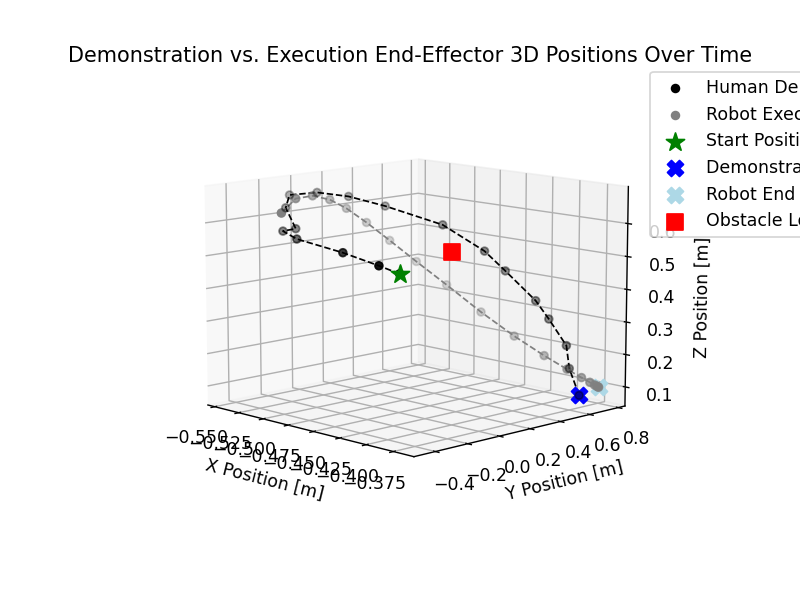

In [18]:
# enable interactive plots in Jupyter Notebook
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111,
                     projection="3d")

label_position_df = test_trajectory[[
    constants.ACTION_DENORMALIZED_LABEL_NAME + "_1",
    constants.ACTION_DENORMALIZED_LABEL_NAME + "_2",
    constants.ACTION_DENORMALIZED_LABEL_NAME + "_3"
]]
estim_position_df = test_trajectory[[
    constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_1",
    constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_2",
    constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_3"
]]

plot_3D_vector_comparison(ax=ax,
                          label_trajectory_df=label_position_df,
                          estim_trajectory_df=estim_position_df,
                          object_position=constants.OBSTACLE_LOCATION,
                          colors=["black", "grey"],
                          traj_s=20,
                          start_s=120,
                          end_s=85)

ax.set_xlabel("X Position [m]")
ax.set_ylabel("Y Position [m]")
ax.set_zlabel("Z Position [m]")
ax.set_title("Demonstration vs. Execution End-Effector 3D Positions Over Time")

ax.legend(bbox_to_anchor=(1.02, 1),
          loc="upper left", borderaxespad=0.0)

plt.show()

## Test Models on Trained Policy Generated Trajectories

In [19]:
episodes_to_run = 10

# create episodes of trajectories by running trained policy model
# take deterministic actions for behavior cloning by setting is_deterministic=True to use mean actions from distribution
robot_trajectories = [functions.generate_session(env=env,
                                                 t_max=constants.TRAJECTORY_SIZE,
                                                 updater_obj=updater_obj,
                                                 replay_buffer=replay_buffer,
                                                 policy_network=policy_network,
                                                 is_policy_inference=True,
                                                 is_policy_gradient_update=False,
                                                 is_deterministic=True) for _ in range(episodes_to_run)]

In [20]:
# choose one randomly initialized state robot trajectory to analyze
robot_trajectory = robot_trajectories[-1]

state_tensor_list = robot_trajectory[0]
action_tensor_list = robot_trajectory[1]
reward_tensor_list = robot_trajectory[3]

## Visualize Randomly Initialized State Trajectory Execution of Trained Policy

<IPython.core.display.Javascript object>


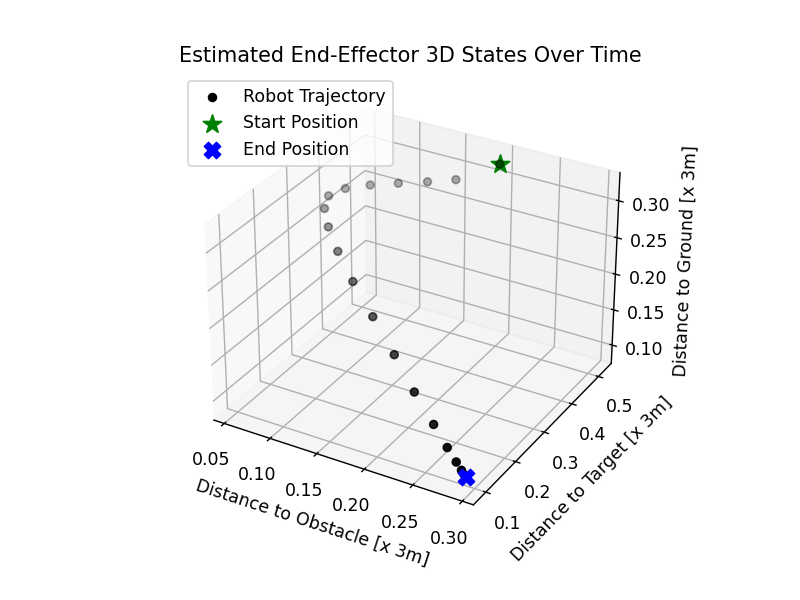

In [21]:
# enable interactive plots in Jupyter Notebook
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111,
                     projection="3d")

plot_3D_vector(ax=ax,
               list_trajectory=state_tensor_list,
               color="black",
               traj_s=20,
               start_s=120,
               end_s=85,
               label="Robot Trajectory")

ax.set_xlabel("Distance to Obstacle [x 3m]")
ax.set_ylabel("Distance to Target [x 3m]")
ax.set_zlabel("Distance to Ground [x 3m]")
ax.set_title("Estimated End-Effector 3D States Over Time")

ax.legend()

plt.show()

<IPython.core.display.Javascript object>


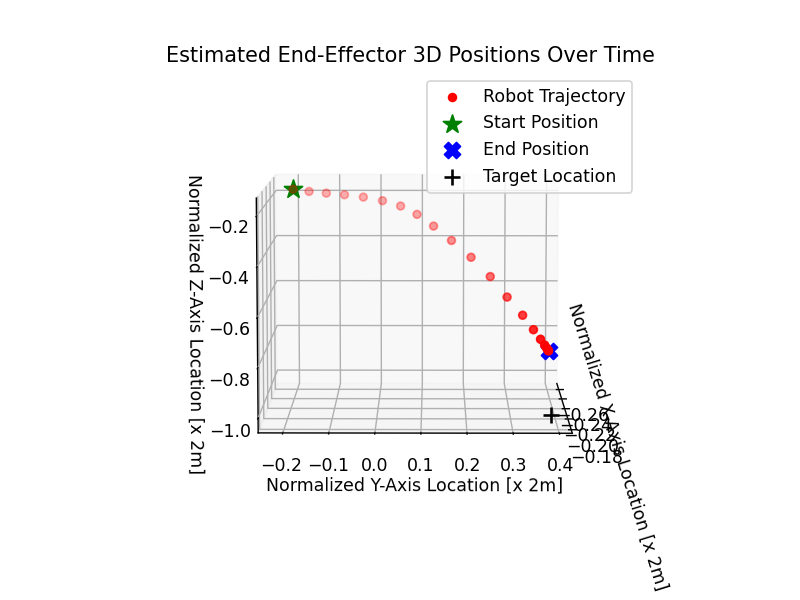

In [22]:
# enable interactive plots in Jupyter Notebook
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111,
                     projection="3d")

plot_3D_vector(env=env,
               ax=ax,
               list_trajectory=action_tensor_list,
               color="red",
               traj_s=20,
               start_s=120,
               end_s=85,
               label="Robot Trajectory")

ax.set_xlabel("Normalized X-Axis Location [x 2m]")
ax.set_ylabel("Normalized Y-Axis Location [x 2m]")
ax.set_zlabel("Normalized Z-Axis Location [x 2m]")
ax.set_title("Estimated End-Effector 3D Positions Over Time")

ax.legend()

plt.show()

<IPython.core.display.Javascript object>


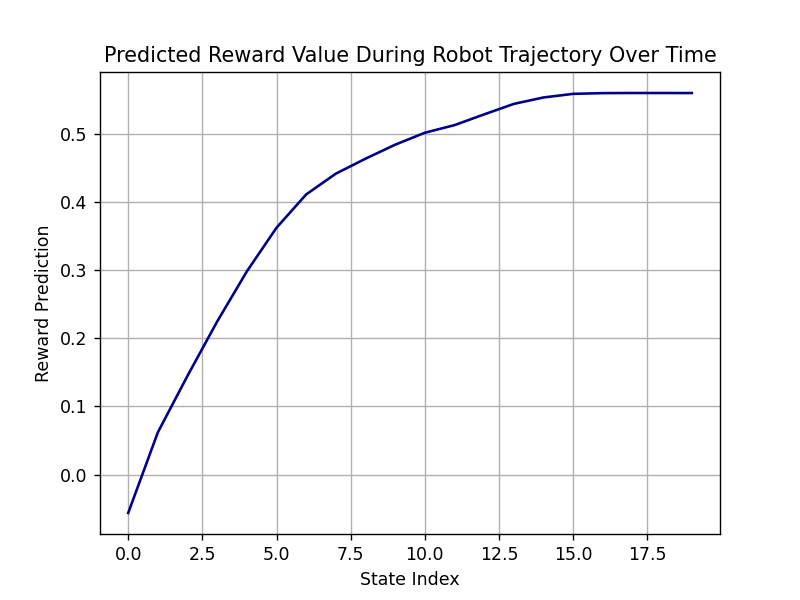

In [23]:
rewards = [reward_tensor[0].item() for reward_tensor in reward_tensor_list]

fig = plt.figure()
plt.plot(rewards, c="darkblue")
plt.xlabel("State Index")
plt.ylabel("Reward Prediction")
plt.title("Predicted Reward Value During Robot Trajectory Over Time")
plt.grid()
plt.show()

## Reset the Model Parameters and Examine the Output of Reward Function

In [24]:
dummy_policy_network = RobotPolicy(state_size=configs.state_size,
                                   hidden_size=configs.hidden_size,
                                   out_size=configs.action_size,
                                   log_std_min=configs.policy_log_std_min,
                                   log_std_max=configs.policy_log_std_max,
                                   device=configs.device)

In [25]:
unlearned_robot_trajectory = [functions.generate_session(env=env,
                                                         t_max=constants.TRAJECTORY_SIZE,
                                                         updater_obj=updater_obj,
                                                         replay_buffer=replay_buffer,
                                                         policy_network=dummy_policy_network,
                                                         is_policy_inference=True,
                                                         is_policy_gradient_update=False,
                                                         is_deterministic=True) for _ in range(episodes_to_run)][0]
dummy_state_tensor_list = unlearned_robot_trajectory[0]
dummy_action_tensor_list = unlearned_robot_trajectory[1]
dummy_reward_tensor_list = unlearned_robot_trajectory[3]

## Visualize Randomly Initialized State Trajectory Execution of Not Trained Policy (Dummy)

<IPython.core.display.Javascript object>


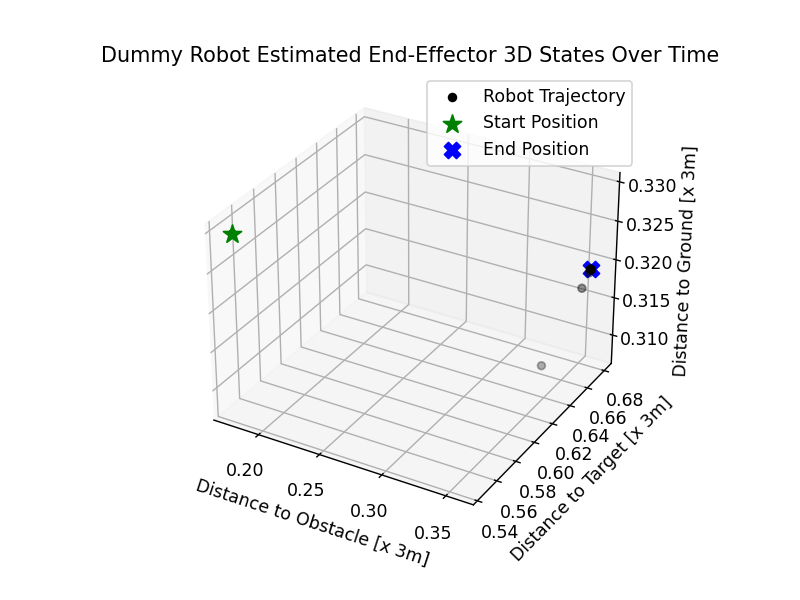

In [26]:
# enable interactive plots in Jupyter Notebook
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111,
                     projection="3d")

plot_3D_vector(ax=ax,
               list_trajectory=dummy_state_tensor_list,
               color="black",
               traj_s=20,
               start_s=120,
               end_s=85,
               label="Robot Trajectory")

ax.set_xlabel("Distance to Obstacle [x 3m]")
ax.set_ylabel("Distance to Target [x 3m]")
ax.set_zlabel("Distance to Ground [x 3m]")
ax.set_title("Dummy Robot Estimated End-Effector 3D States Over Time")

ax.legend()

plt.show()

<IPython.core.display.Javascript object>


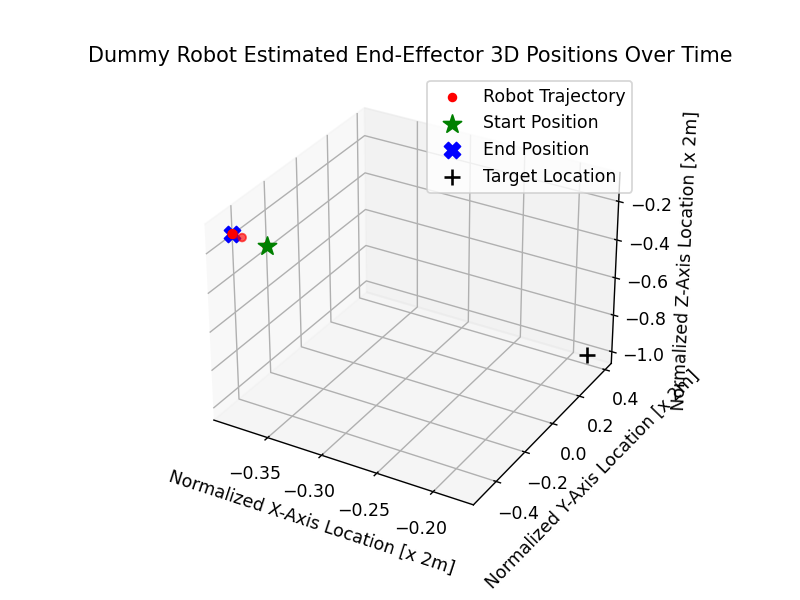

In [27]:
# enable interactive plots in Jupyter Notebook
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111,
                     projection="3d")

plot_3D_vector(env=env,
               ax=ax,
               list_trajectory=dummy_action_tensor_list,
               color="red",
               traj_s=20,
               start_s=120,
               end_s=85,
               label="Robot Trajectory")

ax.set_xlabel("Normalized X-Axis Location [x 2m]")
ax.set_ylabel("Normalized Y-Axis Location [x 2m]")
ax.set_zlabel("Normalized Z-Axis Location [x 2m]")
ax.set_title("Dummy Robot Estimated End-Effector 3D Positions Over Time")

ax.legend()

plt.show()

<IPython.core.display.Javascript object>


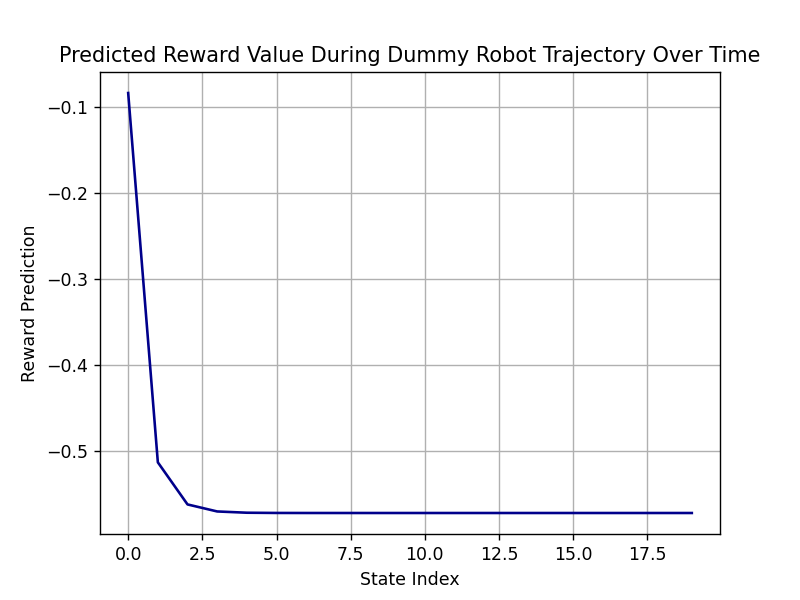

In [28]:
dummy_rewards = [dummy_reward_tensor[0].item() for dummy_reward_tensor in dummy_reward_tensor_list]

fig = plt.figure()
plt.plot(dummy_rewards, c="darkblue")
plt.xlabel("State Index")
plt.ylabel("Reward Prediction")
plt.title("Predicted Reward Value During Dummy Robot Trajectory Over Time")
plt.grid()
plt.show()